In [2]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt

train_image_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset\images'
train_annotation_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset\annotations'

val_image_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset_2\images'
val_annotation_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset_2\annotations'

IMG_HEIGHT = 512
IMG_WIDTH = 640
BATCH_SIZE = 16

def load_dataset_with_corners(image_dir, annotation_dir):
    images = []
    labels = []
    corners_list = []


    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):

            image_path = os.path.join(image_dir, filename)
            img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = img_to_array(img.convert('RGB')) / 255.0
            images.append(img_array)

            annotation_path = os.path.join(annotation_dir, filename.replace('.jpg', '.json').replace('.png', '.json'))
            with open(annotation_path, 'r') as f:
                annotation = json.load(f)
                instance_data = annotation["instances"]
                
                image_corners = []
                image_labels = []
                for instance in instance_data:
                    corners = instance["corners"]
                    defected = instance["defected_module"]
                    image_corners.append([(corner['x'], corner['y']) for corner in corners])
                    image_labels.append(1 if defected else 0)
                
                corners_list.append(image_corners)
                labels.append(image_labels)
    
    return np.array(images), corners_list, labels


train_images, train_corners, train_labels = load_dataset_with_corners(train_image_dir, train_annotation_dir)
print(f"training dataset shapes: {train_images.shape}, corners: {len(train_corners)}, labels: {len(train_labels)}")

val_images, val_corners, val_labels = load_dataset_with_corners(val_image_dir, val_annotation_dir)
print(f"testing dataset shapes: {val_images.shape}, corners: {len(val_corners)}, labels: {len(val_labels)}")


training dataset shapes: (120, 512, 640, 3), corners: 120, labels: 120
testing dataset shapes: (41, 512, 640, 3), corners: 41, labels: 41


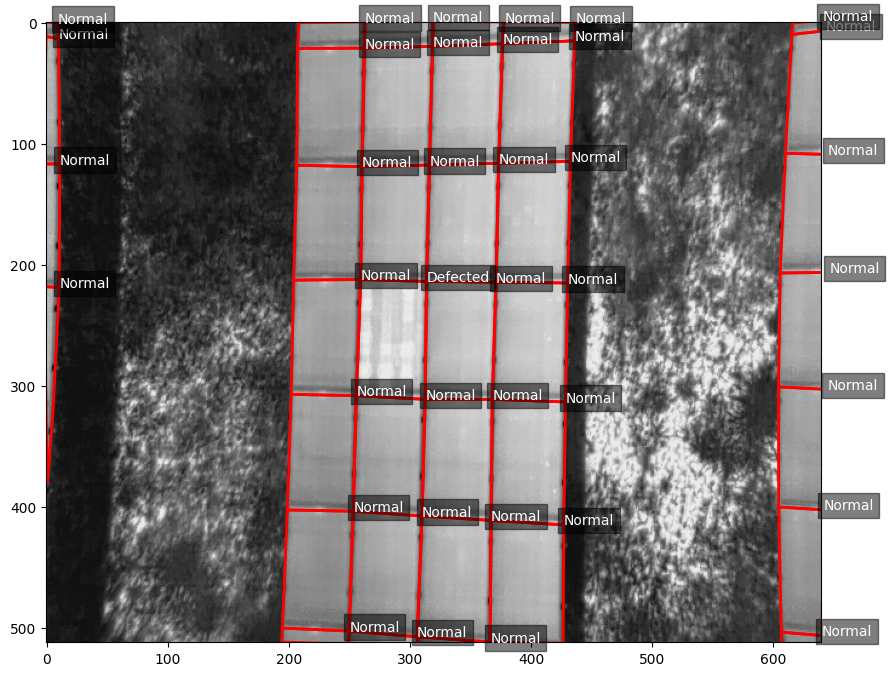

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.preprocessing.image import load_img


def visualize_image_with_bboxes(image, bboxes, labels):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    for i, bbox in enumerate(bboxes):
        polygon = patches.Polygon(bbox, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(polygon)

        label_text = "Defected" if labels[i] == 1 else "Normal"
        ax.text(
            bbox[0][0], bbox[0][1], label_text,
            color='white', fontsize=10,
            bbox=dict(facecolor='black', alpha=0.5)
        )

    plt.show()

sample_idx = 40
visualize_image_with_bboxes(
    train_images[sample_idx], 
    train_corners[sample_idx], 
    train_labels[sample_idx]
)

In [4]:
def build_model():
    # 使用 InceptionV3 替代 ResNet50
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False  # 冻结预训练模型的参数

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # 从卷积层提取全局特征
        layers.Dense(128, activation='relu'),  # 添加全连接层
        layers.Dropout(0.5),  # 加入 Dropout 防止过拟合
        layers.Dense(1, activation='sigmoid')  # 二分类问题，使用 sigmoid 激活函数
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 18, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 262,401
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
def preprocess_labels(labels):
    return np.array([1 if any(label) else 0 for label in labels])

train_labels_binary = preprocess_labels(train_labels)
val_labels_binary = preprocess_labels(val_labels)

print("Model compilation completed")

Model compilation completed


In [7]:
history = model.fit(
    train_images, train_labels_binary,
    validation_data=(val_images, val_labels_binary),
    epochs=10,
    batch_size=BATCH_SIZE
)


Epoch 1/10
8/8 [==============================] - 11s 662ms/step - loss: 0.6107 - accuracy: 0.6583 - val_loss: 0.7246 - val_accuracy: 0.5854
Epoch 2/10
8/8 [==============================] - 1s 179ms/step - loss: 0.5115 - accuracy: 0.8083 - val_loss: 0.8130 - val_accuracy: 0.5854
Epoch 3/10
8/8 [==============================] - 1s 178ms/step - loss: 0.5284 - accuracy: 0.8083 - val_loss: 0.7525 - val_accuracy: 0.5854
Epoch 4/10
8/8 [==============================] - 1s 178ms/step - loss: 0.5008 - accuracy: 0.8083 - val_loss: 0.6834 - val_accuracy: 0.5854
Epoch 5/10
8/8 [==============================] - 1s 179ms/step - loss: 0.4654 - accuracy: 0.8083 - val_loss: 0.6647 - val_accuracy: 0.5854
Epoch 6/10
8/8 [==============================] - 1s 178ms/step - loss: 0.4850 - accuracy: 0.8083 - val_loss: 0.6739 - val_accuracy: 0.5854
Epoch 7/10
8/8 [==============================] - 1s 178ms/step - loss: 0.4585 - accuracy: 0.8083 - val_loss: 0.6707 - val_accuracy: 0.5854
Epoch 8/10
8/8 [===

In [8]:
val_loss, val_acc = model.evaluate(val_images, val_labels_binary, batch_size=BATCH_SIZE)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


3/3 [==============================] - 0s 106ms/step - loss: 0.6168 - accuracy: 0.5854
Validation Loss: 0.6167889833450317, Validation Accuracy: 0.5853658318519592


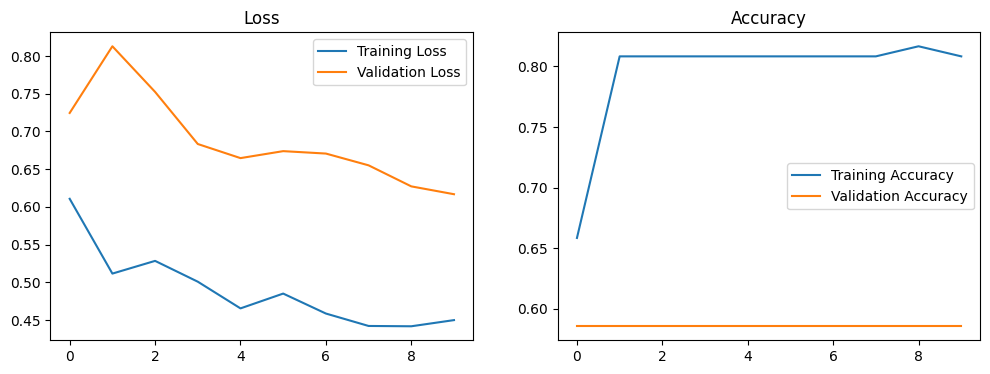

In [9]:
def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

plot_training(history)

In [10]:
model.save("solar_cell_model_with_inceptionv3.h5")
print("Model saved as solar_cell_model_with_inceptionv3.h5")

Model saved as solar_cell_model_with_inceptionv3.h5


In [11]:
from numba import cuda

cuda.select_device(0)
cuda.close()